Sanggoroe, a platform to search and provide information related to teaching job vacancies, can help students, fresh graduates, or anyone who wants to gain teaching experience by providing information related to teaching job vacancies.

Tahapan membuat model ML :

1. [Collecting Data](#step-1) ✅
2. [Exploratory Data Analysis](#step-2) ✅
3. [Data Preprocessing](#step-3) ✅
5. [Training Model](#step-4) ✅
5. [Evaluasi Model](#step-5) ✅
6. [Deployment](#step-6) 


<a name="step-1"></a>
## **1. Data Collecting**

Proses pengumpulan data dikumpulkan secara manual melalui situs lowongan kerja untuk guru yang tersedia di Indonesia

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# from google.colab import drive, auth
# from google.auth import default
# import gspread as gd

In [3]:
# drive.mount('/content/drive')
# auth.authenticate_user()
# creds,_ = default()
# gc = gd.authorize(creds)

In [4]:
# lowongan = gc.open_by_url('https://docs.google.com/spreadsheets/d/1qHqyoNTFhKuLJ_wuSPVpT9InLXo6QiWGf9PMa8AtYiQ/edit?usp=sharing').worksheet('Lowongan Guru')

In [5]:
# lowongan = lowongan.get_all_values()
# data = pd.DataFrame(lowongan)
# data.columns = data.iloc[0]
# data = data.iloc[1:].reset_index(drop=True)

data = pd.read_csv('Dataset/job.csv')

data.head()

,JobID,Jenjang,Kualifikasi,Posisi,Gender,Provinsi,Kota,Pengalaman,Skill,Skill 1,Skill 2,Skill 3,Deskripsi,Gaji,Jenis,Perusahaan,TglPosting,Perusahaan.1,Link,Deskripsi.1
0,1,Kindergarten,Bachelor Degree,Kindergarten Teacher,General,Jawa Barat,Bogor,24,Proficient in English,Experience in teaching kids,Proficient in English,Collaboration,Available for working in the new academic year...,0,Full time,PT Tunas Tuju Asa,2023-05-16,Sekolah,PRESCHOOL & KINDERGARTEN TEACHERS FOR KINDERFI...,Available for working in the new academic year...
1,2,Kindergarten,Bachelor Degree,Islamic Education Teachers,General,Banten,Tangerang,24,Proficient in English,Proficient in Arabic,Read the Qur’an,Experience in teaching kids,"Create environments, activities, and programmi...",0,Full time,PT Kinder Haven Pusaka,2023-05-18,Sekolah,Guru Agama (Religion Student Counselor) - PT K...,"Create environments, activities, and programmi..."
2,3,Kindergarten,Bachelor Degree,Kindergarten Teacher,General,DI Yogyakarta,Sleman,24,NaN,Experience in teaching kids,Leadership,Proficient in English,We are a well-grown English-speaking Pre-schoo...,2200000,Full time,Yayasan Pendidikan Blue Dolphin International,2023-05-18,Sekolah,Preschool and Kindergarten Teacher - Yay. Pend...,We are a well-grown English-speaking Pre-schoo...
3,4,Kindergarten,Bachelor Degree,Kindergarten Teacher,General,Jawa Timur,Surabaya,0,Proficient in English,Experience in teaching kids,Communication,Collaboration,Preparing and delivering lessons to a range of...,0,Full time,Yayasan Intan Eduka,2023-05-18,Sekolah,KINDERGARTEN TEACHER - Yayasan Intan Eduka - 4...,Preparing and delivering lessons to a range of...
4,5,Elementary School,Diploma Degree,Natural Sciences Teacher,General,Jawa Barat,Depok,0,Proficient in English,Natural Sciences,Proficient in English,Experience in teaching kids,"Age max 35 years old, Bachelor degree in Educa...",2000000,Full time,Pratiwi School Depok,2023-05-17,Sekolah,Science and Mathematics Teachers - Pratiwi Sch...,"Age max 35 years old, Bachelor degree in Educa..."


<a name="step-2"></a>
## **2. Exploratory Data Analysis**

Exploratory data analysis atau EDA bertujuan sebagai analisa awal terhadap data dan melihat bagaimana kualitas data untuk meminimalkan potensi kesalahan di kemudian hari. Pada proses ini dilakukan investigasi awal pada data untuk menemukan pola, anomali, menguji hipotesis , memahami distribusi, frekuensi, hubungan antar variabel, dan memeriksa asumsi dengan teknik statistik dan representasi grafik. <br>
Source: Dicoding

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [7]:
data.columns

Index(['JobID', 'Jenjang', 'Kualifikasi', 'Posisi', 'Gender', 'Provinsi',
       'Kota', 'Pengalaman', 'Skill', 'Skill 1', 'Skill 2', 'Skill 3',
       'Deskripsi', 'Gaji', 'Jenis', 'Perusahaan', 'TglPosting',
       'Perusahaan.1', 'Link', 'Deskripsi.1'],
      dtype='object')

In [8]:
# Melihat informasi dasar tentang dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   JobID         230 non-null    int64 
 1   Jenjang       230 non-null    object
 2   Kualifikasi   230 non-null    object
 3   Posisi        230 non-null    object
 4   Gender        230 non-null    object
 5   Provinsi      229 non-null    object
 6   Kota          228 non-null    object
 7   Pengalaman    230 non-null    int64 
 8   Skill         177 non-null    object
 9   Skill 1       230 non-null    object
 10  Skill 2       230 non-null    object
 11  Skill 3       230 non-null    object
 12  Deskripsi     230 non-null    object
 13  Gaji          230 non-null    int64 
 14  Jenis         230 non-null    object
 15  Perusahaan    230 non-null    object
 16  TglPosting    227 non-null    object
 17  Perusahaan.1  230 non-null    object
 18  Link          230 non-null    object
 19  Deskrips

In [9]:
data.isnull().sum()

JobID            0
Jenjang          0
Kualifikasi      0
Posisi           0
Gender           0
Provinsi         1
Kota             2
Pengalaman       0
Skill           53
Skill 1          0
Skill 2          0
Skill 3          0
Deskripsi        0
Gaji             0
Jenis            0
Perusahaan       0
TglPosting       3
Perusahaan.1     0
Link             0
Deskripsi.1     31
dtype: int64

In [10]:
# Melihat statistik deskriptif dasar
data.describe()

,JobID,Pengalaman,Gaji
count,230.000000,230.000000,2.300000e+02
mean,115.500000,8.469565,8.782609e+04
std,66.539462,11.800616,4.023181e+05
min,1.000000,0.000000,0.000000e+00
25%,58.250000,0.000000,0.000000e+00
50%,115.500000,0.000000,0.000000e+00
75%,172.750000,24.000000,0.000000e+00
max,230.000000,60.000000,2.200000e+06


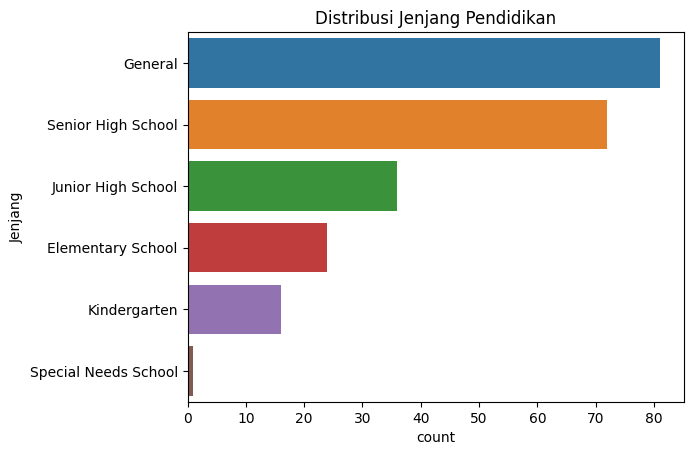

In [11]:
sns.countplot(y='Jenjang', data=data, order = data['Jenjang'].value_counts().index)
plt.title('Distribusi Jenjang Pendidikan')
plt.show()

In [12]:
data['Jenis'].replace('Kontrak', 'Contract', inplace=True)

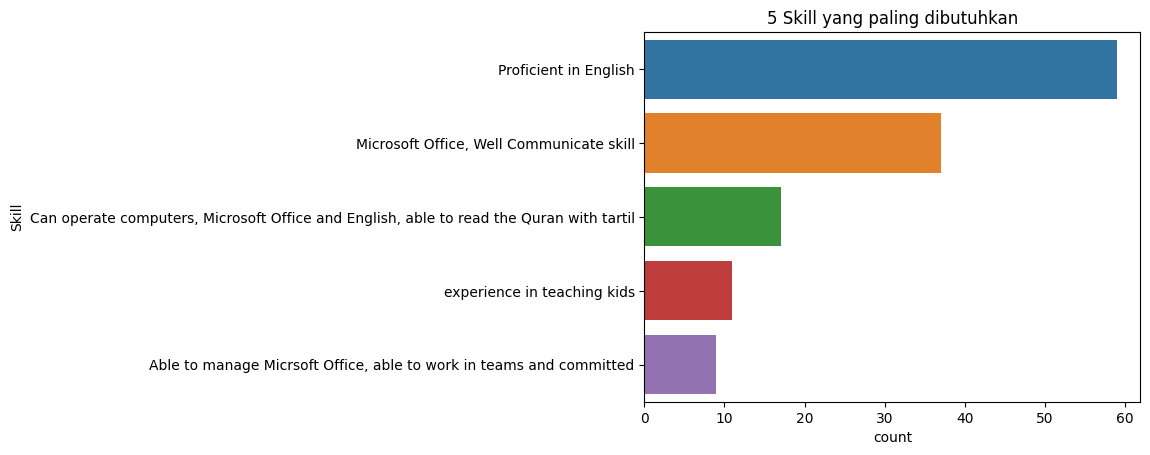

In [13]:
sns.countplot(y='Skill', data=data, order = data['Skill'].value_counts().head(5).index)
plt.title('5 Skill yang paling dibutuhkan')
plt.show()

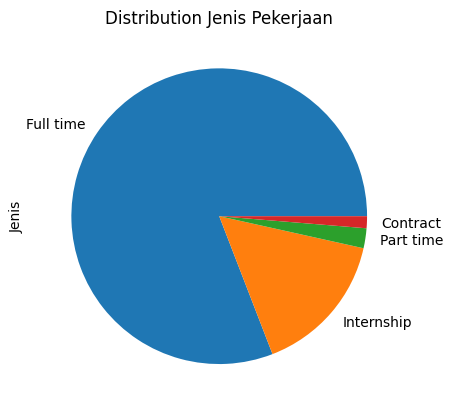

In [14]:
# Plot pie chart untuk 'Jenis Pekerjaan'
data['Jenis'].value_counts().plot(kind='pie')
plt.title('Distribution Jenis Pekerjaan')
plt.show()

In [15]:
data['Posisi'].value_counts()

Kindergarten Teacher                   13
Mathematic Teacher                     12
English teacher                        12
It teacher                             11
Indonesian Teacher                     10
                                       ..
Christian Religion Curriculum Staff     1
English Teacher                         1
Civics Teachers                         1
Special Needs Teacher                   1
Geography Teacher                       1
Name: Posisi, Length: 83, dtype: int64

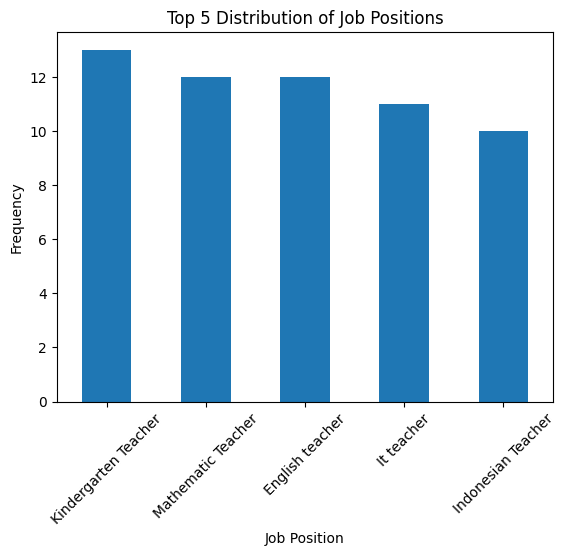

In [16]:
data['Posisi'].value_counts().head(5).plot(kind='bar')
plt.title('Top 5 Distribution of Job Positions')
plt.xlabel('Job Position')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [17]:
print(data.groupby('Jenis')['Posisi'].value_counts())

Jenis       Posisi                    
Contract    Christian Religion Teacher     1
            Informatics Teacher            1
            Kindergarten Teacher           1
Full time   Mathematic Teacher            12
            Indonesian Teacher             9
                                          ..
Internship  Javanese Teacher               1
Part time   It teacher                     2
            English Teacher                1
            English teacher                1
            Indonesian Teacher             1
Name: Posisi, Length: 99, dtype: int64


In [18]:
print(data.groupby('Jenjang')['Posisi'].value_counts())

Jenjang               Posisi                                
Elementary School     Homeroom teacher                          3
                      Mathematic Teacher                        3
                      Elementary School teacher                 2
                      Alquran Teacher                           1
                      Art and Music Teacher                     1
                                                               ..
Senior High School    Pancasila Education Teacher               1
                      Physical Education and Health Teachers    1
                      Physics Teacher                           1
                      Social Sciences Teacher                   1
Special Needs School  Special Needs Teacher                     1
Name: Posisi, Length: 127, dtype: int64


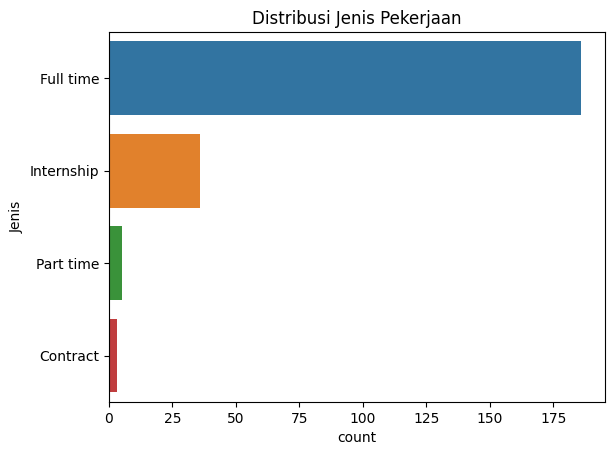

In [19]:
# Melihat distribusi Jenis Pekerjaan
sns.countplot(y='Jenis', data=data, order = data['Jenis'].value_counts().index)
plt.title('Distribusi Jenis Pekerjaan')
plt.show()

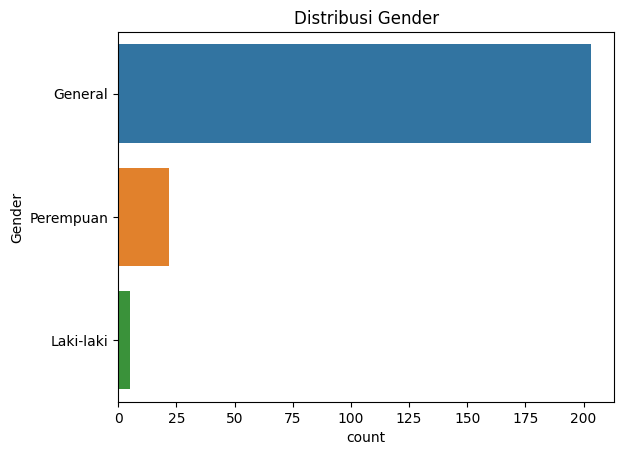

In [20]:
# Melihat distribusi Gender
sns.countplot(y='Gender', data=data, order = data['Gender'].value_counts().index)
plt.title('Distribusi Gender')
plt.show()

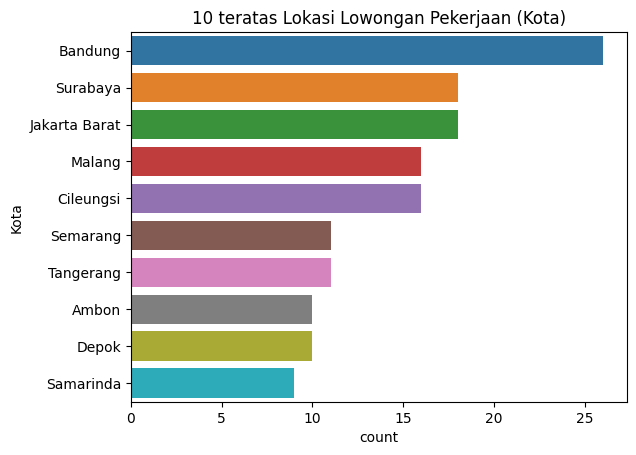

In [21]:
# Melihat distribusi Lokasi Pekerjaan
sns.countplot(y='Kota', data=data, order = data['Kota'].value_counts().head(10).index)
plt.title('10 teratas Lokasi Lowongan Pekerjaan (Kota)')
plt.show()


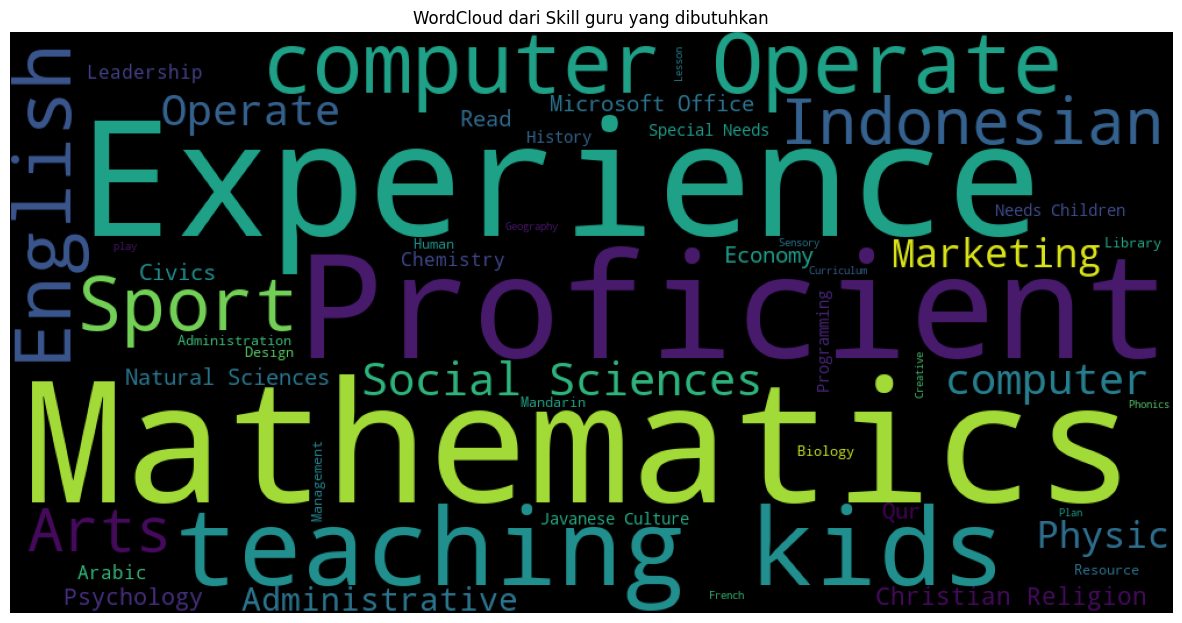

In [22]:
# Membuat WordCloud dari Skill yang dibutuhkan
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(data['Skill 1']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud dari Skill guru yang dibutuhkan')
plt.show()


<a name="step-3"></a>
## **3. Data Preprocessing**
Data preprocessing adalah tahap di mana data diolah lebih lanjut sehingga menjadi siap dipakai dalam pengembangan model ML. Dengan kata lain, proses ini mengubah dan mentransformasi fitur-fitur data ke dalam bentuk yang mudah diinterpretasikan dan diproses oleh algoritma machine learning. Termasuk di dalam data preprocessing adalah proses data cleaning dan data transformation.<br>
Source: Dicoding


In [23]:
#subsetting only needed columns and not considering the columns that are not necessary
cols = list(['JobID']+['Posisi']+ ['Skill 1']+ ['Skill 2']+ ['Skill 3'] )
final_lowongan =data[cols]
final_lowongan.columns = ['Job.ID','Position','Skill1','Skill2','Skill3']
final_lowongan.head() 


,Job.ID,Position,Skill1,Skill2,Skill3
0,1,Kindergarten Teacher,Experience in teaching kids,Proficient in English,Collaboration
1,2,Islamic Education Teachers,Proficient in Arabic,Read the Qur’an,Experience in teaching kids
2,3,Kindergarten Teacher,Experience in teaching kids,Leadership,Proficient in English
3,4,Kindergarten Teacher,Experience in teaching kids,Communication,Collaboration
4,5,Natural Sciences Teacher,Natural Sciences,Proficient in English,Experience in teaching kids


In [43]:
final_lowongan["Skill1"] = final_lowongan["Skill1"].str.replace(' ', '_')
final_lowongan["Skill2"] = final_lowongan["Skill2"].str.replace(' ', '_')
final_lowongan["Skill3"] = final_lowongan["Skill3"].str.replace(' ', '_')

C:\Users\win 10\AppData\Local\Temp\ipykernel_11432\629958968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["Skill1"] = final_lowongan["Skill1"].str.replace(' ', '_')
C:\Users\win 10\AppData\Local\Temp\ipykernel_11432\629958968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["Skill2"] = final_lowongan["Skill2"].str.replace(' ', '_')
C:\Users\win 10\AppData\Local\Temp\ipykernel_11432\629958968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [44]:
final_lowongan["pos_skill"] = final_lowongan["Skill1"] +", "+ final_lowongan["Skill2"]+", "+ final_lowongan["Skill3"]
final_lowongan.pos_skill.values
# final_lowongan.pos_skill.values

C:\Users\win 10\AppData\Local\Temp\ipykernel_11432\2886655381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["pos_skill"] = final_lowongan["Skill1"] +", "+ final_lowongan["Skill2"]+", "+ final_lowongan["Skill3"]


array(['Experience_in_teaching_kids, Proficient_in_English, Collaboration',
       'Proficient_in_Arabic, Read_the_Qur’an, Experience_in_teaching_kids',
       'Experience_in_teaching_kids, Leadership, Proficient_in_English',
       'Experience_in_teaching_kids, Communication, Collaboration',
       'Natural_Sciences, Proficient_in_English, Experience_in_teaching_kids',
       'Mathematics, Operate_a_computer, Experience_in_teaching_kids',
       'Sport, Creative, Leadership', 'Arts, Read_the_Qur’an, Creative',
       'Social_Sciences, Read_the_Qur’an, Leadership',
       'Civics, Read_the_Qur’an, Operate_a_computer',
       'Operate_a_computer, Experience_in_teaching_kids, Proficient_in_English',
       'Operate_a_computer, Experience_in_teaching_kids, Proficient_in_English',
       'Operate_a_computer, Experience_in_teaching_kids, Proficient_in_English',
       'Operate_a_computer, Experience_in_teaching_kids, Proficient_in_English',
       'Operate_a_computer, Experience_in_teaching

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\win
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
final_lowongan["pos_skill"] = final_lowongan["pos_skill"].astype(str)

C:\Users\win 10\AppData\Local\Temp\ipykernel_11432\3035871098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["pos_skill"] = final_lowongan["pos_skill"].astype(str)


In [28]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Create an object of class PorterStemmer
porter = PorterStemmer()

# Define the stop words
stop_words = set(stopwords.words('english')) 

# Function to preprocess the data
def preprocess_data(data):
    # Lowercasing the data
    data = data.lower()
    # Removing the punctuations, except comma
    data = re.sub(r'[^\w\s,]', '', data)
    # Stemming the data
    data = porter.stem(data)
    # Removing the stop words
    data = " ".join(word for word in data.split() if word not in stop_words)
    return data

# Preprocessing the job descriptions
final_lowongan["pos_skill"] = final_lowongan["pos_skill"].apply(preprocess_data)

C:\Users\win 10\AppData\Local\Temp\ipykernel_11432\3278478514.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["pos_skill"] = final_lowongan["pos_skill"].apply(preprocess_data)


In [29]:
# final_lowongan['pos_skill'].replace('', np.nan, inplace=True)
# final_lowongan['pos_skill'].isnull().sum()
# final_lowongan.dropna(subset=['pos_skill'],inplace=True)
final_lowongan["pos_skill"][0]

'experience_in_teaching_kids, proficient_in_english, collabor'

In [30]:
data2 = list(final_lowongan["pos_skill"].values)

In [31]:
# Membuat list_of_descriptions
list_of_descriptions = [desc.split(', ') for desc in data2]

In [32]:
# Membuat dan menyimpan model Word2Vec
model = Word2Vec(list_of_descriptions, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Fungsi untuk mendapatkan vektor
def get_vector(word_list):
    vector_sum = sum(model.wv[word] for word in word_list if word in model.wv)
    return vector_sum / len(word_list)

# Membuat vektor pekerjaan
job_vectors = np.array([get_vector(desc) for desc in list_of_descriptions])
job_vectors = np.reshape(job_vectors, (len(job_vectors), -1))  # reshape job vectors to 2D

<a name="step-4"></a>
## **4. Training Model**


In [33]:
# Membuat dan melatih model rekomendasi
rec_model = Sequential()
rec_model.add(Dense(128, activation='relu', input_dim=100))
rec_model.add(Dense(64, activation='relu'))
rec_model.add(Dense(len(job_vectors[0]), activation='linear'))  # Output layer

rec_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Melatih model dan menyimpan history
history = rec_model.fit(job_vectors, job_vectors, epochs=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 1s 3ms/step - loss: 1.0771e-05 - mae: 0.0026
Epoch 2/50
8/8 [==============================] - 0s 2ms/step - loss: 9.6956e-06 - mae: 0.0025
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 9.5907e-06 - mae: 0.0025
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 9.3959e-06 - mae: 0.0025
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 9.3293e-06 - mae: 0.0025
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 9.2702e-06 - mae: 0.0024
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 9.2884e-06 - mae: 0.0025
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 9.2524e-06 - mae: 0.0024
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 9.1855e-06 - mae: 0.0024
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 9.0341e-06 - mae: 0.0024
Epoch 11/50
8/8 [==============================] 

<a name="step-5"></a>
## **5. Evaluasi Model**

In [34]:
loss, mae = rec_model.evaluate(job_vectors, job_vectors)
print('Loss:', loss)
print('MAE:', mae)

8/8 [==============================] - 0s 2ms/step - loss: 5.8776e-06 - mae: 0.0019
Loss: 5.877629064343637e-06
MAE: 0.0019410576205700636


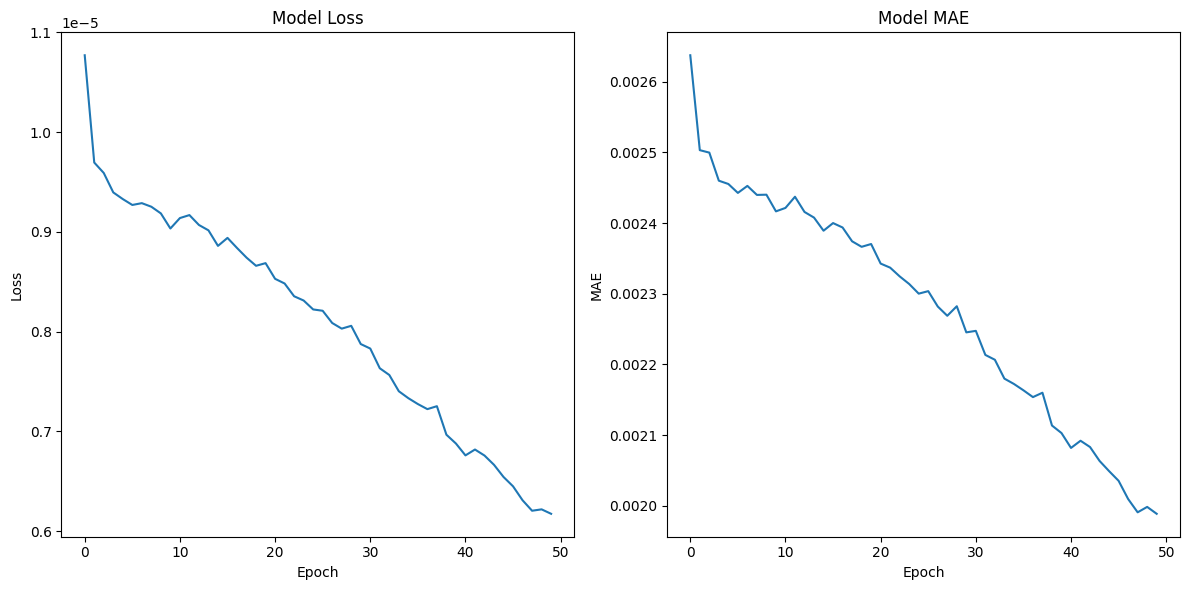

In [35]:
import matplotlib.pyplot as plt

# Membuat figure
plt.figure(figsize=(12, 6))

# Membuat plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Membuat plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')

# Menampilkan plot
plt.tight_layout()
plt.show()


In [36]:
final_lowongan.isnull().sum()

Job.ID       0
Position     0
Skill1       0
Skill2       0
Skill3       0
pos_skill    0
dtype: int64

In [37]:
# Fungsi untuk mendapatkan posisi yang mirip dengan skill 1 dan mengutamakan skill pertama
def get_similar_positions(skill_list):
    skill_vector = get_vector(skill_list)
    predicted_vector = rec_model.predict(np.reshape(skill_vector, (1, -1)))[0]
    
    skill1_vector = get_vector([skill_list[0]])
    skill1_similarity = cosine_similarity([skill1_vector], job_vectors)[0]
    
    similarities = 0.7 * skill1_similarity + 0.3 * cosine_similarity([predicted_vector], job_vectors)[0]
    
    df = pd.DataFrame(data={
        'JobID' : final_lowongan["Job.ID"],
        'Position' : final_lowongan["Position"],
        'Job': data2,
        'Similarity': similarities
    })
    df = df.sort_values(by='Similarity', ascending=False)
    return df

# Mencoba sistem rekomendasi
my_list = ["Experience_in_teaching_kids", "communication", "profficient_in_english"]
lowercase_list = [item.lower() for item in my_list]


# Mencoba sistem rekomendasi
get_similar_positions(lowercase_list).head(10)

1/1 [==============================] - 0s 88ms/step


,JobID,Position,Job,Similarity
21,22,English Teacher,"proficient_in_english, experience_in_teaching_...",0.610352
0,1,Kindergarten Teacher,"experience_in_teaching_kids, proficient_in_eng...",0.596997
172,173,Kindergarten Teacher,"experience_in_teaching_kids, proficient_in_eng...",0.596997
13,14,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670
20,21,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670
18,19,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670
14,15,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670
10,11,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670
11,12,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670
12,13,It teacher,"operate_a_computer, experience_in_teaching_kid...",0.592670


In [38]:
rec_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
Total params: 27,684
Trainable params: 27,684
Non-trainable params: 0
_________________________________________________________________


In [39]:
rec_model.save('rec_model.h5')

In [40]:
# final_lowongan.to_csv('jobs.csv')

In [41]:
# rec_model.save('model')